# Pipeline

### Overview 
Given a Spotify username, we will request a user's public playlists from the Spotify API and aggregate them into a dataframe of [audio features](https://developer.spotify.com/documentation/web-api/reference/#endpoint-get-audio-features) which represent certain attributes of each track. We will then collect data of the same form for each of this user's Spotify friends (users that this user is "following"), and aggregate the friend data into a weighted source for recommendations.

After authenticating with the API, we can see a lot of public data on each user. We can get all of their public playlists, retrieve the tracks from each playlist, and get audio features for the tracks (this last step is done in batches of 50 tracks at a time). 

For each track, we can obtain:
- 'acousticness'
- 'danceability'
- 'energy'
- 'instrumentalness'
- 'liveness'
- 'loudness'
- 'speechiness'
- 'tempo'
- 'valence'

We also have attributes like the track's title, artist, and unique Spotify URI, but the audio features are the attributes that will be useful for training a model.

Our expectation is that songs with similar audio features are similar enough for a user who likes one to enjoy the other(s). This is why we intend to use k-nearest neighbors, but more on that later. This audio feature data is essential to make song recommendations becuase it is the only set of numerical features that we have from the Spotify API, so it's the only way to meaningfully conceptualize distance between songs in space. Spotify has its own endpoint for recommendations that takes min, max, and target audio features as attributes, so we're hoping that means we're headed in the right direction when implementing our own audio-feature-based recommender.

To simplify analysis, each audio feature will have its own column in our output DataFrame.  For example:

<img src="completed dataframe screenshot upload filepath">


### Pipeline Overview

We will accomplish this task with four functions:

- `get_user_playlist_data(username)`
    - returns json list of simplified playlist objects from Spotify API
- `get_track_ids(req_data_json)`
    - gets a list of track IDs from the given list of playlist objects, track IDs will be used to request audio feature data
- `get_audio_features(user_tracks)`
    - given a list of track IDs, requests audio features for tracks in batches of 50 and adds track features as entries to dataframe
- `clean_user_af_df(audio_features_df)`
    - cleans given dataframe by removing redundant columns and those that are not useful for our model, retaining track ID and audio features

All four functions are wrapped into one convenience function for ease of calling:

- `get_user_audio_features(username)`
    - wraps the ETL process in one conveninence function, the result of which is a clean dataframe of audio features for tracks found in this user's public playlists
    
As well as one web scraping script:


- **Scrape list of games:** use `get_url()` and `clean_top_games()` in a loop to collect n pages of top games (100 * n games), populating a DataFrame `df_game`
- **Get meta data per game:** loop through each row of `df_game`, query and process the individual game's webpage via `get_url()` and `clean_game_meta()` using the previously collected url and append the remaining features to `df_game`

### A few convenience functions for endpoint generation

In [13]:
import requests
import json
import collections
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from bs4 import BeautifulSoup

# NOTE: tokens only last 1 hour. we need a new access token every time we want to run this
access_token = 'BQDr3lKWYeo96zuHHR6ZLE-hyQex0IzgJCmhavuyi81CZtTD_aj_PgfR8cuBsHLj920D84DVxnbZsa7vFORHoKkirqKUYpsbpRSOlLAb-lZUNmnH8G7zZgRyuwrHykHeVr2T94jDj111GCj_sjdq3npu'

headers = {
    'Authorization': f'Bearer {access_token}',
    'Content-Type': 'application/json',
    'Accept': 'application/json'
}

In [10]:
def get_user_playlists_endpoint(user_id):
    """ endpoint generator used to get list of playlist objects for given user. This function gets the URL,
        simplification to playlist_id's happens elsewhere

        Args:
            user_id (str): base 62 identifier found at end of spotify URI, unique to each user
    
        Return:
            fstring (str): url used to get user's playlists
    """
    # suffix of URL: gets items list from paging obj, gets playlist_id's from each item
    # note: wrapped in a paging object i think
    return f"https://api.spotify.com/v1/users/{user_id}/playlists?limit=50&fields=items(id)"
  

def get_playlist_tracks_endpoint(playlist_id):
    """ endpoint generator used to get list of track objects for given playlist

        Args:
            playlist_id (str): base 62 identifier found at end of spotify URI, unique to each playlist
    
        Return:
            fstring (str): url used to get a list of track objects for given playlist
    """
    
    # gets items list from paging obj
    return f"https://api.spotify.com/v1/playlists/{playlist_id}/tracks?fields=items"


def get_tracks_audio_features_endpoint(tracks_str):
    """
    produces a url endpoint to retrieve audio features for a list of tracks,
    supplied as a comma separated list of Spotify IDs

    :param tracks_str: a comma separated list of Spotify IDs that point to tracks
    :return: fstring url used to get list of track objects
    """
    return f"https://api.spotify.com/v1/audio-features?ids={tracks_str}"

### Get user's playlists, get tracks from the playlists, get audio features for the tracks
#### Get user's playlists

In [9]:
def get_user_playlist_data(username):
    """
    Given a username, pulls all public playlist data for that user
    Args:
        username (str): Spotify username for the user for which we want recommendations
    Returns:
        req_data_json (json list): json equivalent of request data from user playlists endpoint
    """
    # print string to show that it's working
    print(f'Collecting audio features for {username}:')

    # TODO catch exception if bad username
    # gets an endpoint for playlist objects corresponding to this user's playlists
    user_playlists_endpoint = get_user_playlists_endpoint(username)
    
    # gets json list of playlist objects (this user's playlists) from Spotify API
    user_request_data = requests.get(user_playlists_endpoint, headers=headers)
    
    # convert given json array of dicts wrapped in a paging object to json
    req_data_json = user_request_data.json() 
    
    return req_data_json

#### get tracks from the playlists

In [8]:
def get_track_ids(req_data_json):
    """
    Given user playlists request data, compiles a list of track IDs, pulling up to
    100 tracks from each of the given public playlists. A list allows for duplicates,
    could use a set if we want to exclude duplicates in a later version.
    Args:
        req_data_json (json list): json list of playlist objects (representing this user's public playlists)
    Returns:
        track_list (array): a list of track IDs representing a user's entire public library
    """
    
    # get items field from json, array of dicts
    playlist_dict = req_data_json.get('items') 

    # NOTE: if this is slow, use some numpy thing instead
    track_list = []
    if playlist_dict == None:
        print("there's nothing in the playlist dict. you probably need a new access token, they expire quickly")
    
    else:
        for playlist_id_dict in playlist_dict:
            
            # get playlist Spotify ID string
            playlist_id = playlist_id_dict.get('id') 
            
            # pass playlist_id to endpoint generator, get all songs in playlist
            # TODO catch exception if bad playlist id
            playlist_tracks_endpoint = get_playlist_tracks_endpoint(playlist_id)
            
            # request a playlist object, metadata and json list of track_id's
            playlist_req_data = requests.get(playlist_tracks_endpoint, headers=headers)
            playlist_paging_obj_dict = playlist_req_data.json()
            track_dict = playlist_paging_obj_dict.get('items')

            # get all tracks from this playlist
            for track in track_dict:
                track_id = track.get('track').get('id')
                track_list.append(track_id)

    # print("Num tracks for user: " + str(len(track_set)))
    return track_list

#### get audio features for the tracks

In [7]:
def get_audio_features(user_tracks):
    """Given a list of track IDs, generates a dataframe with audio feature data 
        for each track. Note that we get track audio features in batches. Adds
        the results to a dataframe.
    Args:
        user_tracks (array): a list of track IDs representing a user's entire public library        
    Returns:
        audio_features_df (pd.DataFrame): each row is a track, columns are audio features
    """
    
    # spotify api is quirky and can only handle batches of requests. 
    # split user_tracks list into chunks small enough for spotify api to accept
    split_user_tracks = [user_tracks[i:i + 50] for i in range(0, len(user_tracks), 50)]  
    
    # init dataframe, rows are tracks, columns are audio features
    audio_features_df = pd.DataFrame()
    
    # for each sublist of all the tracks collected from the user
    for track_sublist in split_user_tracks:
        
        # make list of spotify URIs separated by commas because that's what spotify wants for the endpoint
        sublist_str = ','.join(track_sublist)
        
        # get endpoint to retrieve audio features for our batch of 50 tracks
        tracks_endpoint = get_tracks_audio_features_endpoint(sublist_str)
        
        # execute the get request
        sublist_req = requests.get(tracks_endpoint, headers=headers)
        print(f'sublist_req: {sublist_req}')
        
        # for each track in the sublist response data
        for track_req in sublist_req.json()['audio_features']:
            
            # convert track_req into a pandas series
            row_series = pd.Series(track_req)
            # print(json.dumps(track_req, indent=2))
            
            """
            HEY this is a bad idea. make a list, add dicts to a list, convert
            to a dataframe at the end. should do it this way instead:
            https://stackoverflow.com/questions/13784192/creating-an-empty-pandas-dataframe-then-filling-it/56746204#56746204
            """
            # append row_series to our accumulator audio_features_df
            audio_features_df = audio_features_df.append(row_series, ignore_index=True)

    return audio_features_df

### clean the user's dataframe

In [6]:
def clean_user_af_df(audio_features_df):
    """Creates and returns a new dataframe that retains only the track ID and the useful audio features 
        from the given df.
    Args:
        audio_features_df (pd.DataFrame): each row is a track, columns are attributes including audio features
    Returns:
        cleaned_af_df (pd.DataFrame): each row is a track, columns are audio features
    """
    # a list of the features we want to retain. Track ID and audio features
    features_list = ['id', 'acousticness', 'danceability', 'energy', 
                 'instrumentalness', 'liveness', 'loudness', 
                 'speechiness', 'tempo', 'valence']
    
    # take a subset of the original dataframe columns, only columns in features_list
    cleaned_af_df = audio_features_df[features_list]
    
    return cleaned_af_df

### all ETL functions wrapped in one convenient function

In [5]:
def get_user_audio_features(username):
    """A convenience function that wraps our pipeline for each user. 
    Given a username, pulls all public playlist data for that user. Then, 
    compiles a list of track IDs from all the user's public playlists. Then,
    gets track audio features and adds the results to a dataframe. Last,
    clean the dataframe to only retain the id and audio feature columns.
    Args:
        username (str): Spotify username for the user for which we want recommendations
    Returns:
        clean_af_df (pd.DataFrame): each row is a track, columns are attributes including audio features
 """
    # Pulls all public playlist data for user
    user_req_data = get_user_playlist_data(username)
    
    # gets track IDs for all tracks in user's public playlists, as a list
    user_tracks = get_track_ids(user_req_data)
    
    # gets dataframe of audio features for each track
    audio_features_df = get_audio_features(user_tracks)
    
    # cleans dataframe of audio features, eliminates redundant columns and useless attributes.
    clean_af_df = clean_user_af_df(audio_features_df)
    
    return clean_af_df

#### The cell below is our attempt at web scraping the user's following list so that we can build a dataframe based on their tracks.

#### We were unsuccessful at this because Spotify blocks webscrapers, but for now this is not a problem because we can pass the usernames of the friends we want to base the recommendations on direclty

In [15]:
def get_user_friends(username):
    """The Spotify API doesn't let us get a list of a user's friends. So what do we do?
        We webscrape it.
    Args:
        username (str): Spotify username whose friends we will get
    Returns:
        friends_list (list): list of the usernames of this Spotify user's friends
    """
    
    # get the html for the webpage containing who this user follows
    following_response = requests.get(f'https://open.spotify.com/user/{username}/following')
    
    # get the text from the html str for the webpage
    following_soup = BeautifulSoup(following_response.text)
    print(following_soup)
    
    # accumulate users following in list
    following_list = []
    
    
    # drill down to the container that has the following users in it. 
    following_class_name = '_5aac821edb25f0e281f50522021abbe4-scss _6424f268be3505ebab663700d60ebaa6-scss _7321ea8cd8e8baded34054347ab0be48-scss'
    following_container = following_soup.find('div', class_=following_class_name)
    
    # extract each user from the container of users
    following_class_name = '_3802c04052af0bb5d03956299250789e-scss'
    following_html_list = following_container.find_all('div', class_=following_class_name)
    
    # for each of the users/artists in the list
    for user_html in following_html_list:
        name_and_username_tag = user_html.find('a', class_='f7ebc3d96230ee12a84a9b0b4b81bb8f-scss')
        
        # TODO we need to get the href field of this tag which will be of the form /user/{username}
        
        # filter out artists that this user is following, get only the users, not the /artists/
        if href_str[:6] == '/user/':
            following_list.append(href_str[6:])
        
    return following_list
    
    
# get_user_friends('brenderman3')

### testing get_audio_features() function for a few users, and loading the dataframes that we got to CSVs.

In [ ]:
# Pulls all public playlist data for user 'dudu.massud' (eddie)
eddie_df = get_user_audio_features('dudu.massud')
eddie_df.to_csv('eddie_song_data.csv')

# Pulls all public playlist data for user 'briannannaj' (bri)
bri_df = get_user_audio_features('briannannaj')
bri_df.to_csv('bri_song_data.csv')

# Pulls all public playlist data for user 'rafalapetina' (rafa)
rafa_df = get_user_audio_features('rafalapetina')
rafa_df.to_csv('rafa_song_data.csv')

# Pulls all public playlist data for user 'brenderman3' (brendan)
brendan_df = get_user_audio_features('brenderman3')
brendan_df.to_csv('brendan_song_data.csv')

# Pulls all public playlist data for user 'dvhgzdwi45q7g1bn7znolytqu' (aditya)
aditya_df = get_user_audio_features('dvhgzdwi45q7g1bn7znolytqu')
aditya_df.to_csv('aditya_song_data.csv')

# for an unknown reason, the code breaks when we run it for my friend matt.
# get_user_audio_features('mattp0irier')

In [16]:
# load dataframes from the CSVs we saved so that we don't have to run everything again

df_eddie = pd.read_csv('eddie_song_data.csv')
df_bri = pd.read_csv('bri_song_data.csv')
df_rafa = pd.read_csv('rafa_song_data.csv')
df_brendan = pd.read_csv('brendan_song_data.csv')
df_aditya = pd.read_csv('aditya_song_data.csv')

df_eddie

,Unnamed: 0,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,0,0.192,https://api.spotify.com/v1/audio-analysis/20Mu...,0.741,231964.0,0.645,20MuVazoNMv6xjKPnRFOxG,0.000000,11.0,0.1630,-5.116,0.0,0.0963,149.070,4.0,https://api.spotify.com/v1/tracks/20MuVazoNMv6...,audio_features,spotify:track:20MuVazoNMv6xjKPnRFOxG,0.4880
1,1,0.194,https://api.spotify.com/v1/audio-analysis/4S7Y...,0.598,238307.0,0.252,4S7YHmlWwfwArgd8LfSPud,0.133000,2.0,0.0992,-15.086,1.0,0.0644,120.064,4.0,https://api.spotify.com/v1/tracks/4S7YHmlWwfwA...,audio_features,spotify:track:4S7YHmlWwfwArgd8LfSPud,0.0352
2,2,0.339,https://api.spotify.com/v1/audio-analysis/3F1g...,0.422,225780.0,0.349,3F1gjSkTX9kvxOo6BnlRNd,0.000240,4.0,0.1080,-12.424,0.0,0.3150,57.000,4.0,https://api.spotify.com/v1/tracks/3F1gjSkTX9kv...,audio_features,spotify:track:3F1gjSkTX9kvxOo6BnlRNd,0.1340
3,3,0.634,https://api.spotify.com/v1/audio-analysis/71Aa...,0.450,160160.0,0.300,71AaGUlQ7I5dRgDEQpdnI4,0.000003,7.0,0.1420,-9.530,1.0,0.0477,96.394,4.0,https://api.spotify.com/v1/tracks/71AaGUlQ7I5d...,audio_features,spotify:track:71AaGUlQ7I5dRgDEQpdnI4,0.2070
4,4,0.231,https://api.spotify.com/v1/audio-analysis/4Q34...,0.647,193839.0,0.667,4Q34FP1AT7GEl9oLgNtiWj,0.000000,5.0,0.1330,-5.563,1.0,0.3040,172.080,4.0,https://api.spotify.com/v1/tracks/4Q34FP1AT7GE...,audio_features,spotify:track:4Q34FP1AT7GEl9oLgNtiWj,0.7040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,279,0.488,https://api.spotify.com/v1/audio-analysis/1kNV...,0.675,217846.0,0.493,1kNVJQEkobOlyfbctPZ4fs,0.000000,1.0,0.0730,-5.197,0.0,0.0792,129.979,4.0,https://api.spotify.com/v1/tracks/1kNVJQEkobOl...,audio_features,spotify:track:1kNVJQEkobOlyfbctPZ4fs,0.8170
280,280,0.539,https://api.spotify.com/v1/audio-analysis/26Wp...,0.621,166400.0,0.700,26WpOBpHiIMoBuMEIwtOCH,0.000000,8.0,0.1520,-5.502,1.0,0.2470,149.902,4.0,https://api.spotify.com/v1/tracks/26WpOBpHiIMo...,audio_features,spotify:track:26WpOBpHiIMoBuMEIwtOCH,0.7040
281,281,0.485,https://api.spotify.com/v1/audio-analysis/6Pa6...,0.671,271440.0,0.443,6Pa6VpdGS8OfiVOEnNAHHw,0.000283,9.0,0.1120,-12.776,1.0,0.0389,79.275,4.0,https://api.spotify.com/v1/tracks/6Pa6VpdGS8Of...,audio_features,spotify:track:6Pa6VpdGS8OfiVOEnNAHHw,0.5890
282,282,0.945,https://api.spotify.com/v1/audio-analysis/2x8T...,0.632,204931.0,0.398,2x8TNY9KwNvD19gVGs4WOP,0.000000,6.0,0.2280,-6.615,1.0,0.3730,90.695,4.0,https://api.spotify.com/v1/tracks/2x8TNY9KwNvD...,audio_features,spotify:track:2x8TNY9KwNvD19gVGs4WOP,0.6330


# Visuals

In [17]:
# all necessary imports:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

In [18]:
# list of audio features that we want to graph
features_list = ['acousticness', 'danceability', 'energy', 
                 'instrumentalness', 'liveness', 'loudness', 
                 'speechiness', 'tempo', 'valence']

# dict of audio features that we want to graph
# keys are features, values are (min, max) range tuples
features_dict = {'acousticness'    :(0.0, 1.0), 
                 'danceability'    :(0.0, 1.0), 
                 'energy'          :(0.0, 1.0), 
                 'instrumentalness':(0.0, 1.0), 
                 'liveness'        :(0.0, 1.0), 
                 'loudness'        :(-60.0, 0.0), 
                 'speechiness'     :(0.0, 1.0), 
                 'tempo'           :(0.0, 300.0), 
                 'valence'         :(0.0, 1.0)}

In [27]:
def graph_audio_features(df_tracks):
    """ graphs the distribution of each audio feature for 
        this user as a histogram subplot
    
        Args:
            df_tracks (pd.DataFrame): each row is a track, columns are audio features
    
        Returns:
            generates a figure that's not returned
    """

    # style points
    sns.set() 

    # for each audio feature
    for feature in features_list:

        # this will be a 3x3 plot
        plt.subplot(3, 3, features_list.index(feature) + 1)
        
        # make 10 bins between the range of possible values for the feature
        bin_max = features_dict[feature][1]
        bin_min = features_dict[feature][0]
        feature_bins = np.linspace(bin_min, bin_max, num=10)

        # add axis labels
        plt.xlabel(feature)
        plt.ylabel('count')
        
        # create a histogram with all the data for the given feature
        # distributed aongst the bins
        plt.hist(df_tracks[feature], bins=feature_bins)

        # add spacing and scale
        plt.subplots_adjust(wspace=.3, hspace=.35)    
        plt.gcf().set_size_inches(15, 7)
        
        # set title
        plt.suptitle('Audio Features for Given User')
        
        plt.savefig('user_audio_features_hist.pdf')

## The subplots of histograms show the data for a single user's music taste

We chose to graph the features that are significant in understanding the types of music the user likes. 

By analyzing each user's subplots, the reader can understand various aspects of the user's taste. 

If one of the histogram is very skewed that means the user is very specific about what he likes regarding that feature. 

If the histogram looks flat, almost like a rectangle, then the user doesn't have a strong preference in that feature.

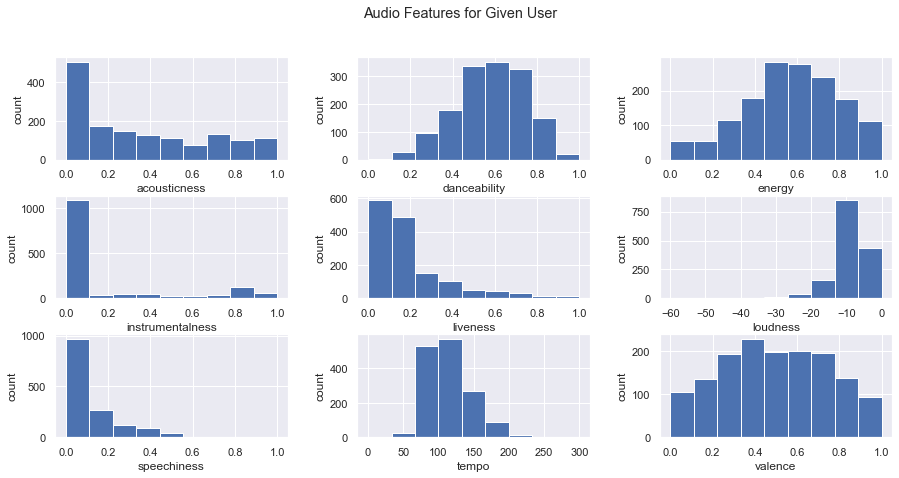

In [28]:
# subplot for Brendan's tracks:
graph_audio_features(df_brendan)

### Some of the easy take aways from the subplots above are that Brendan tends to prefer:
1. music with a low acousticness level, but still listens to plenty with varied levels
1. music with a medium level of danceability, but this feature doesn't seem to be super strcitve for him
1. music with low instrumentalness levels, and he feels strongly about this!
1. low level of liveness in his tracks
1. higher levels of loudness
1. low speechiness
1. doesn't seem to care about valence levels

## Visualizing multiple user's audio features preferences

In [30]:
def user_radar_chart_values(df_tracks):
    """ calculates NORMALIZED median value for 
        each audio feature for this user's dataframe
    
        Args:
            df_tracks (pd.DataFrame): each row is a track, columns are audio features
   
        Returns:
            radar_values (list): list of values for each audio feature
    """
    
    # accumulate normalized medians
    norm_meds_list = []
    
    # for each audio feature:
    for feature in features_list:
        
        # get median value for this column
        feat_median = df_tracks[feature].median()
    
        
        # loudness is a special case. 0dB is the max, -60dB is the min
        if feature == 'loudness':
            # add 60dB to the feat median to get a value between 0 and 60 
            # normalize loudness by dividing by max value
            normalized_feat_median = (feat_median + 60.0) / 60.0 * 100
        else:
            # normalize median by dividing by max value for this feature
            normalized_feat_median = feat_median / features_dict[feature][1] * 100
            
        # add norm feat median to our list
        norm_meds_list.append(normalized_feat_median)
    
    return norm_meds_list

In [34]:
def compare_friends(friend_dict):
    """ generate a radar plot overlaying feature values for friends to see how they compare
    
        Args:
            friends_dict (dict): keys are usernames, values are arrays of audio feature medians
    
        Returns:
            plots a radar graph comparing multiple users' preferences
    """

    fig = go.Figure()

    # for each friend, add a radar plot
    for friend in friend_dict.items():
        # plot this friend's radar plot
        fig.add_trace(go.Scatterpolar(
            
          # list of feats' median values
          r=friend[1],
            
          # features to be graphed
          theta=features_list,
          fill='toself',
            
          # whose data does this belong to
          name=friend[0]))

    fig.update_layout(polar=dict(radialaxis=dict(visible=True,range=[0.0, 100.0])), 
                      showlegend=True)
    
    fig.write_html('users_features_radar.html')

    fig.show()

In [35]:
# initialize our dictionary, keys are usernames, values are arrays of audio feature medians
friends_dict = {}

friends_dict['brenderman3'] = user_radar_chart_values(df_eddie)
friends_dict['briannannaj'] = user_radar_chart_values(df_bri)
friends_dict['dudu.massud'] = user_radar_chart_values(df_rafa)
friends_dict['rafalapetina'] = user_radar_chart_values(df_brendan)

compare_friends(friends_dict)

# Multiple users' preferences

This [radar chart](https://plotly.com/python/radar-chart/) allows the reader to visualize how different users like their music.

It is very easy to see the areas where the audio features preferences overlap and where they differ. 

It also allows the reader to know each user's preference for each of the features through the mouse interactions.


For the values of each feature we decided to use the median value. We started by using the mean, but quickly realized that if a user listens to two main types of music that have opposing values for features, then the mean would return something in the middle, which would be an incorrect recommendatino for this user. 
By using the median we eliminate that problem.